# Visualize Today's Traffic Accidents in the City of Austin
##### Miguel Novo Villar
##### December, 2022 (More to be added)

## Modules

In [134]:
#Import data science modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Scraping
from sodapy import Socrata

#Time
from datetime import datetime, timedelta

#GEOSPATIAL
import geopandas as gpd
import contextily as cx
#Folium for heatmaps

import folium
from folium import plugins

#Timeseries Analysis
import calendar

#Load Images
from IPython.display import Image

#Spatial Clustering
from sklearn.cluster import DBSCAN #Regular clustering
from st_dbscan import ST_DBSCAN #Spatio Temporal Clustering

## Retrieve and transform data

##### We need to get data from data.austintexas.gov and autenticate to load the entire dataset

In [135]:
MyAppToken = "MyAppTokenfrom_data.austintexas.gov"

client = Socrata("data.austintexas.gov", #website
                MyAppToken, #token from portal
                 username="mymail@gmail.com", #username
                 password="mypasswords") #password

#Retrieve from the desired repository
results = client.get("dx9v-zd7x", limit = 1000000000)

#Zips
Austin_zips = gpd.read_file("Z:\Clases\CLASE\Master Rochester\Fall_2022\InterviewPrep\ReadAustinData\Zip Code\geo_export_5b8f0432-d113-478a-b2a5-18fba0156b66.shp")[["geoid10", "geometry"]]
Austin_zips.rename(columns = {"geoid10": "ZIP"}, inplace = True)

#Convert to pandas DataFrame, timestamp and sort by date descending
results_df = pd.DataFrame.from_records(results)
results_df["published_date"] = pd.to_datetime(results_df.published_date, utc=True)\
                                                                        .map(lambda x: x.tz_convert('America/Chicago'))#Convert to central time
results_df= results_df.sort_values(by="published_date", ascending= False)
results_df = results_df.drop(columns = ["traffic_report_status_date_time"])#remove useless columns for time
print("All time accidents recorded: ", results_df.shape[0])

All time accidents recorded:  304182


# Transform to geopandas

Create geodataframe with accidents from today

In [136]:
today = results_df[(results_df['published_date'] > str(pd.to_datetime(datetime.utcnow() - timedelta(hours=36))))] #Use last 1.5 day of data

gdf = gpd.GeoDataFrame(today, 
                        geometry=gpd.points_from_xy(today.longitude, today.latitude),
                        crs ="EPSG:4326").drop(["location"],axis = 1)
                        
print("Accidents recorded today: ", today.shape[0])

Accidents recorded today:  208


# Visualize

#### Accidents today

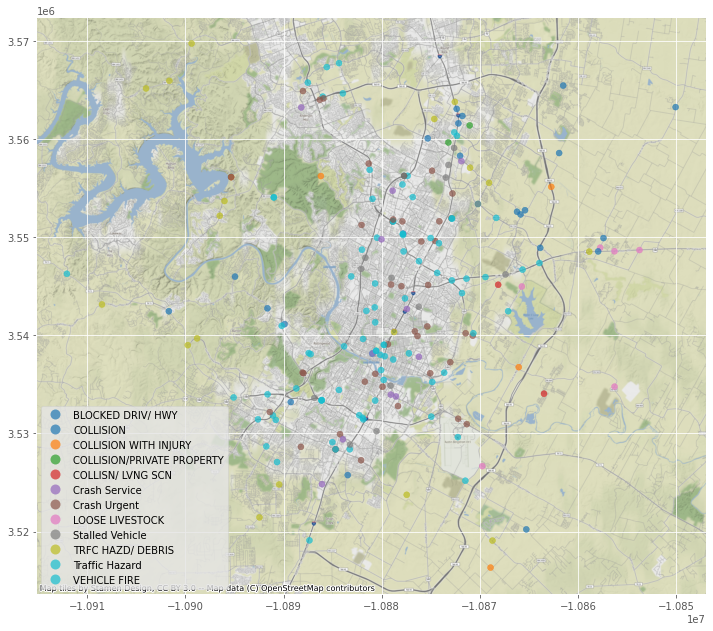

In [137]:
#Transform
gdf = gdf.to_crs(epsg=3857)
# # #create the plot

ax = gdf.plot(figsize = (12,12),legend = True, alpha=0.7, column = "issue_reported")
cx.add_basemap(ax, zoom = 13)

#### Accidents today - ZIP code Level

In [138]:
#Convert to the SAME  crs: 
#ORIGINAL : # gdf in 3857 &  Austin in 4326
Austin_zips = Austin_zips.to_crs(epsg=3857) #Convert both to 3857

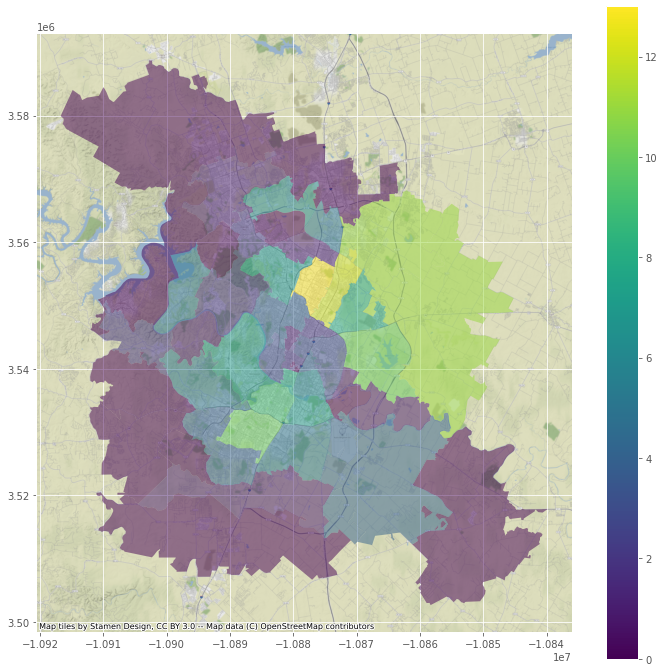

In [139]:
# Lamda function for intersecction
f = lambda x:np.sum(gdf.intersects(x))
Austin_zips["accidents_in_area"] = Austin_zips['geometry'].apply(f)

ax = Austin_zips.plot(column='accidents_in_area', figsize = (12,12),legend = True, alpha=0.5)
cx.add_basemap(ax, zoom = 13)

# HotSpots and ColdSpots

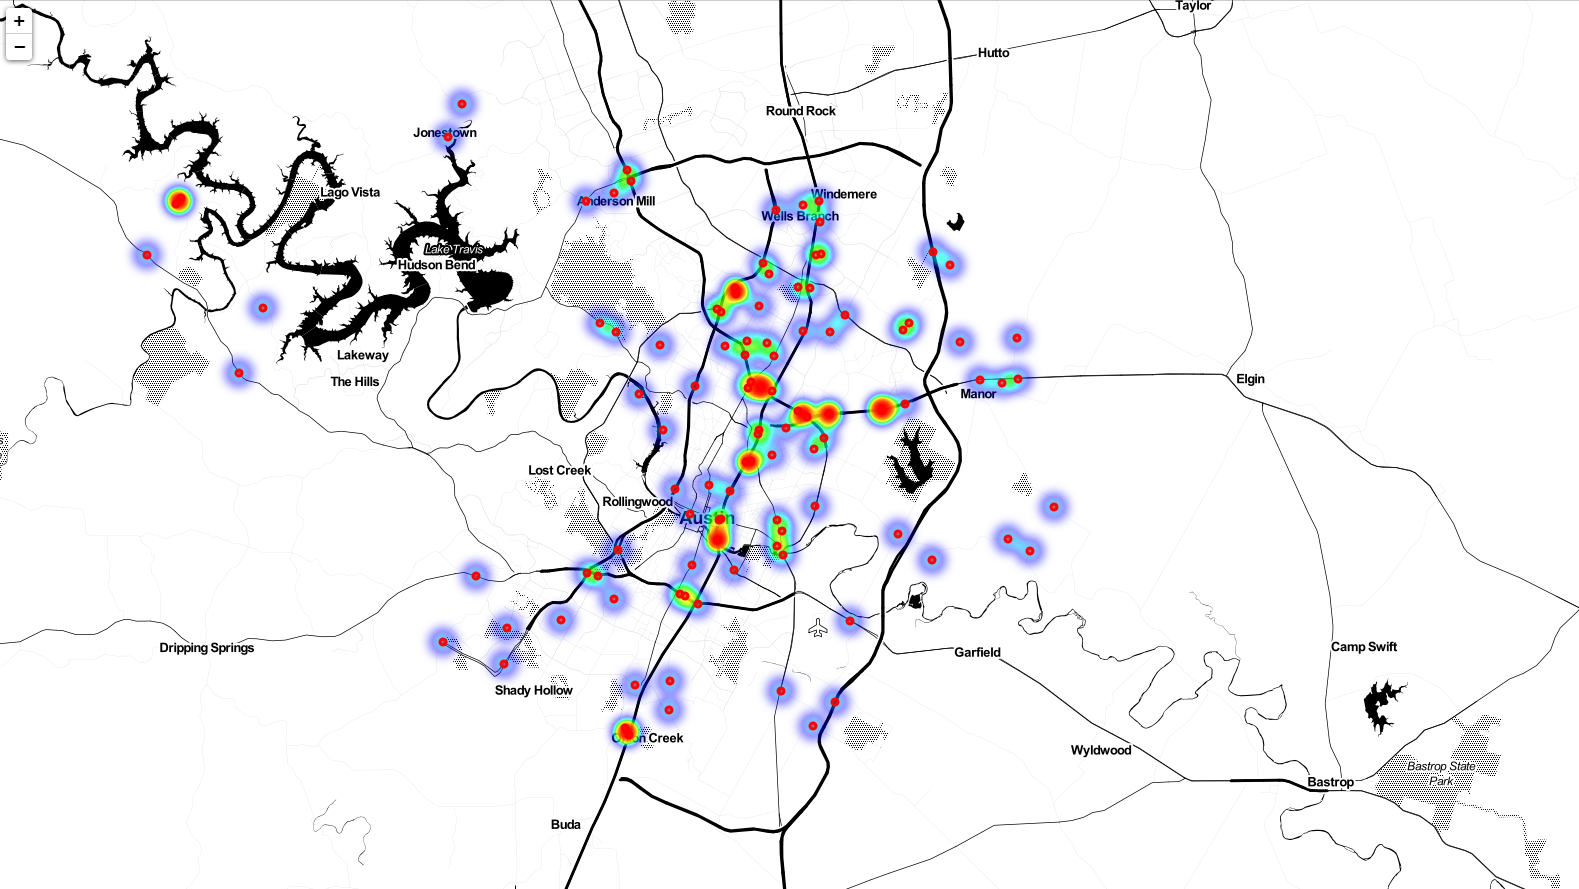

In [162]:
#Center the map in Austin 30.292673,-97.685967
Austin = folium.Map(location=[30.292673,-97.685967], tiles='Stamen Toner', zoom_start=10.5)

#Add Data to the map from the intial pandas dataframe (today)
for i,row in today.iterrows():
    folium.CircleMarker((row.latitude,row.longitude), radius=3, weight=3, color='red', fill_color='red', fill_opacity=.5).add_to(Austin)

#Create heatmap
Austin.add_child(plugins.HeatMap(data=today[['latitude', 'longitude']], radius=15, blur=10, name = "HotSpots and ColdSpots of Accidents in Austin"))

#Plot Map
Austin

# #Visualization will not show on GitHub
%matplotlib inline
Image("Z:\Clases\CLASE\Master Rochester\Fall_2022\InterviewPrep\ReadAustinData\Images\hotspots.png")

# TIME-SERIES ANALYSIS

In [141]:
results_df.head(2)

traffic_report_id  \
304180  06A3BCF49EA79E579CA1A11A5FBD97385E551A74_16718...   
304179  C8FEC85A455710F14E0055CA980D0E274E25B882_16718...   

                  published_date issue_reported                location  \
304180 2022-12-23 16:25:46-06:00   Crash Urgent  (30.373029,-97.726786)   
304179 2022-12-23 16:24:11-06:00   Crash Urgent  (30.252652,-97.742523)   

         latitude   longitude                          address  \
304180  30.373029  -97.726786  9052-9072 Research Blvd Svrd Sb   
304179  30.252652  -97.742523           500-blk E RIVERSIDE DR   

       traffic_report_status  
304180                ACTIVE  
304179                ACTIVE

In [142]:
print("Total number of accidents: ", results_df.shape[0])

Total number of accidents:  304182


Transform timestamp string to time format

In [143]:
results_df['date'] =  pd.to_datetime(results_df['published_date'], format='%Y-%m-%dT%H:%M:%S.%f', utc=True)\
                                                                        .map(lambda x: x.tz_convert('America/Chicago'))#Convert to central time
                                            
results_df = results_df.drop(columns = ["published_date"]) #drop old time column
results_df = results_df[results_df["date"].dt.year != 1970] #we have a data point from 1970 (outlier)
results_df.info() #verify time transformation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304182 entries, 304180 to 40484
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype                          
---  ------                 --------------   -----                          
 0   traffic_report_id      304182 non-null  object                         
 1   issue_reported         304182 non-null  object                         
 2   location               304182 non-null  object                         
 3   latitude               304103 non-null  object                         
 4   longitude              304103 non-null  object                         
 5   address                304182 non-null  object                         
 6   traffic_report_status  302489 non-null  object                         
 7   date                   304182 non-null  datetime64[ns, America/Chicago]
dtypes: datetime64[ns, America/Chicago](1), object(7)
memory usage: 20.9+ MB


## Timeseries Visualization Across the Entire Dataset

<AxesSubplot: title={'center': 'Accidents in a Single Day '}, xlabel='date', ylabel='Cummulative Accidents'>

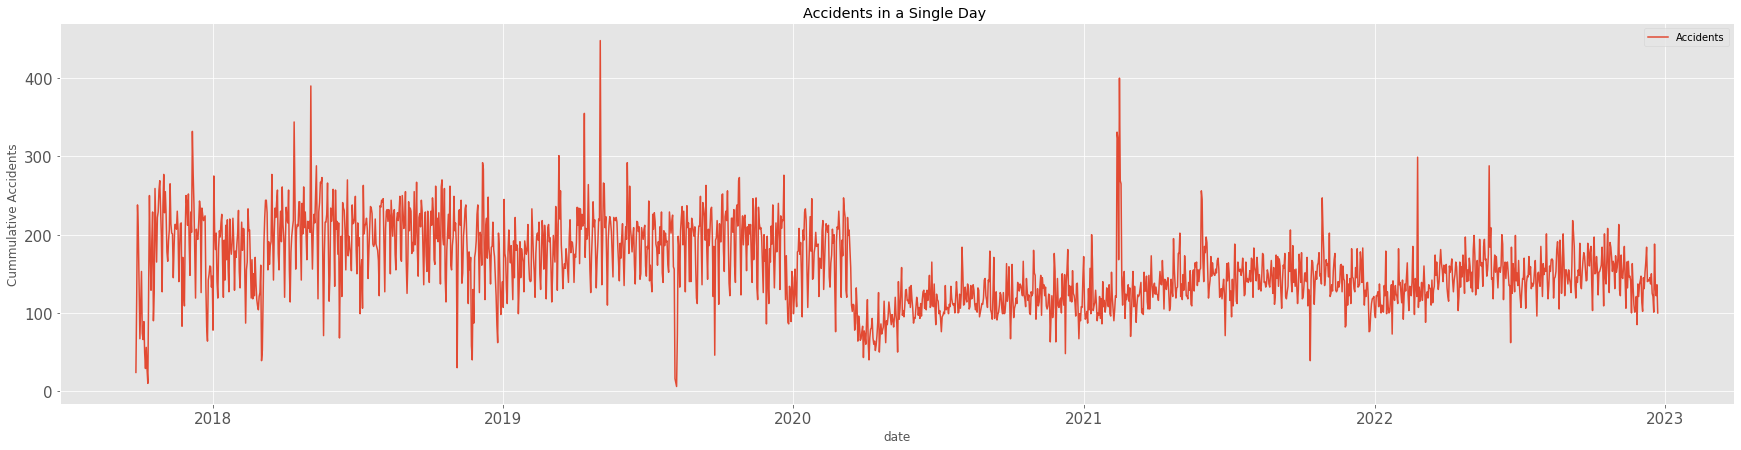

In [145]:
accidents_single_day = results_df.groupby(results_df['date'].dt.date).count().rename(columns={"date":"Accidents"}).Accidents
accidents_single_day.plot(figsize=(30,7), title="Accidents in a Single Day ", ylabel="Cummulative Accidents", fontsize = 15, legend = True)

### Per Month (2021)

Text(0, 0.5, 'Number of accidents')

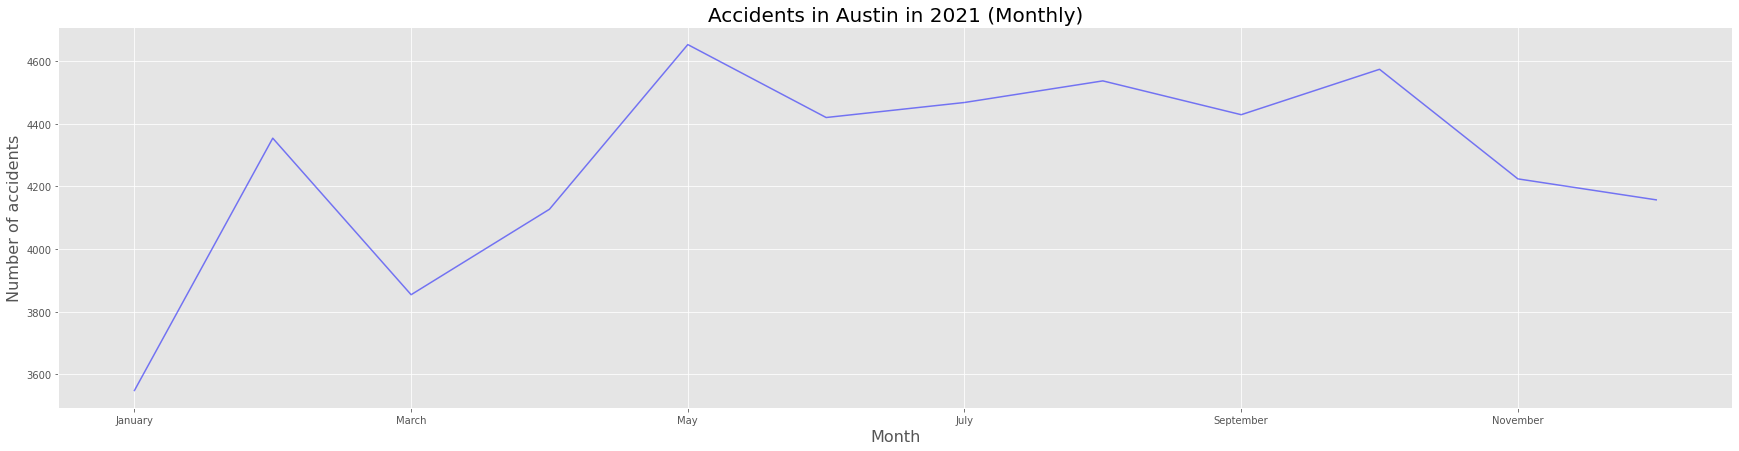

In [146]:
# Number of accident per month
accidents_month = results_df[results_df['date'].dt.year == 2021].groupby(results_df['date'].dt.month).count().date

# Replace the month integers by month names.
accidents_month.index=[calendar.month_name[x] for x in range(1,13)]

plt.style.use('ggplot')

# plot accidents per month
accidents_month.plot(figsize=(30,7), color='blue', alpha=0.5)

# # title and x,y labels
plt.title('Accidents in Austin in 2021 (Monthly)', fontsize=20)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16)

### Per Day 2021

Text(0, 0.5, 'Number of accidents')

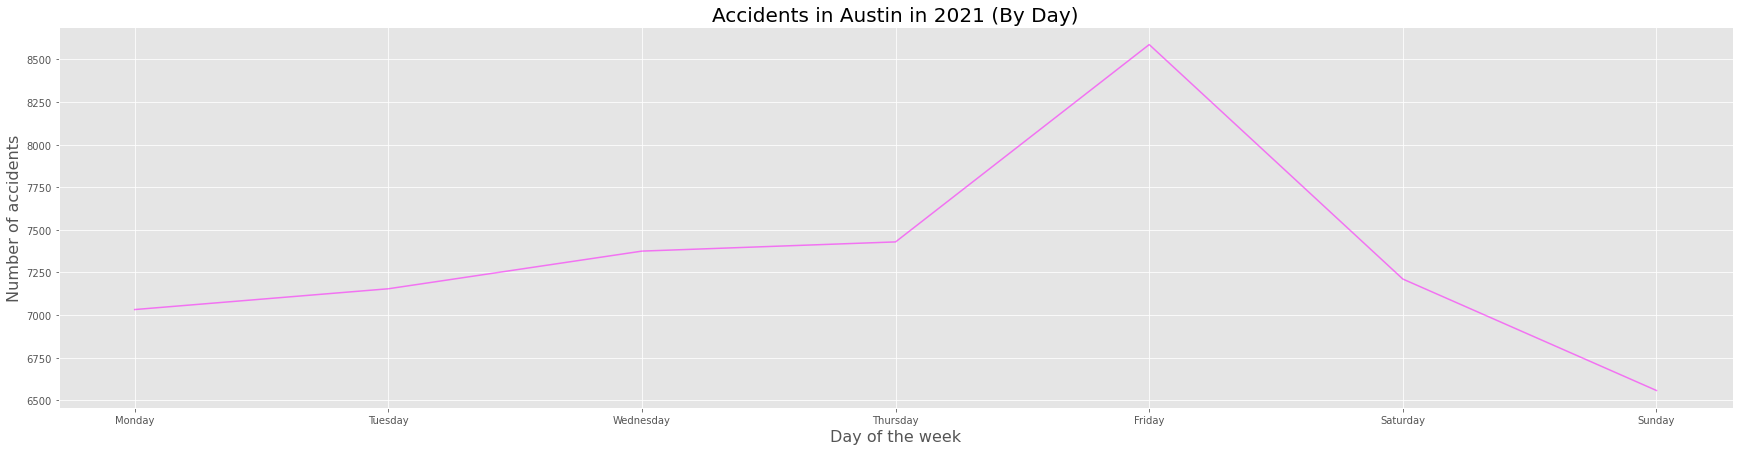

In [147]:
# Number of accident per day of the week
accidents_day = results_df[results_df['date'].dt.year == 2021].groupby(results_df['date'].dt.dayofweek).count().date

# Replace the day integers by day names.
accidents_day.index=[calendar.day_name[x] for x in range(0,7)]

# plot accidents per day
accidents_day.plot(figsize=(30,7), color='magenta', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Austin in 2021 (By Day)', fontsize=20)
plt.xlabel('Day of the week',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16)

### Per hour 2021

Text(0, 0.5, 'Number of accidents')

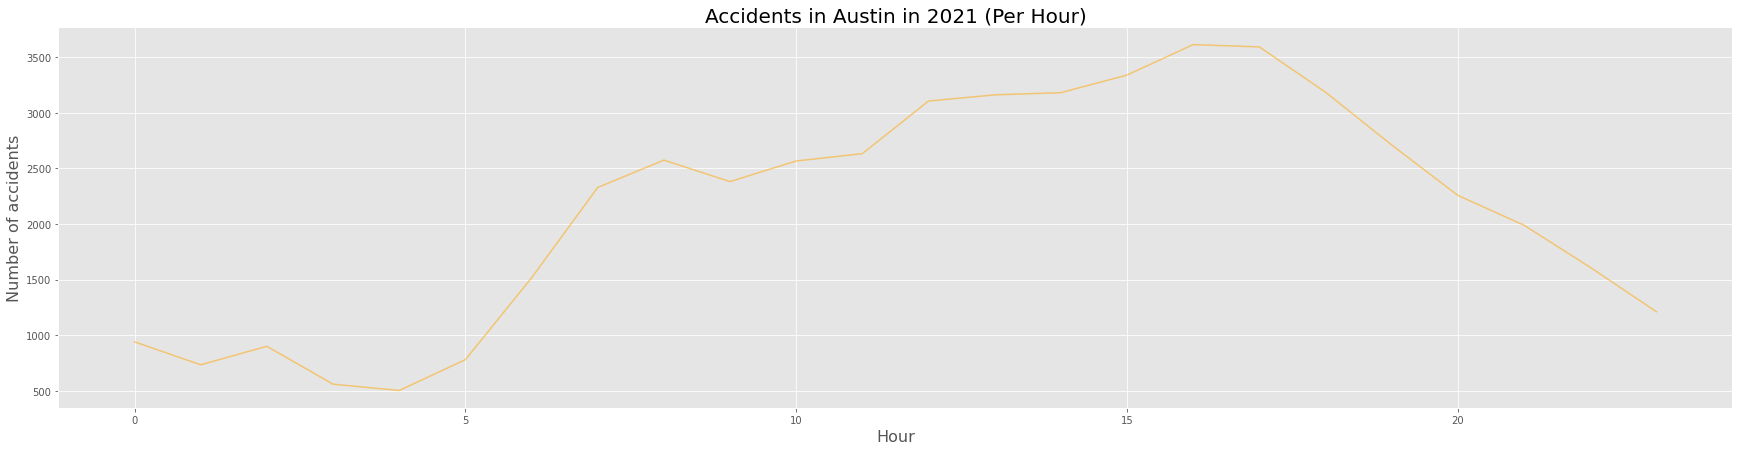

In [148]:
# Number of accident per hour
accidents_hour = results_df[results_df['date'].dt.year == 2021].groupby(results_df['date'].dt.hour).count().date

# plot accidents per hour
accidents_hour.plot(figsize=(30,7), color='orange', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Austin in 2021 (Per Hour)', fontsize=20)
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16)

# SPATIAL CLUSTERTING

## DBSCAN CLUSTER

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


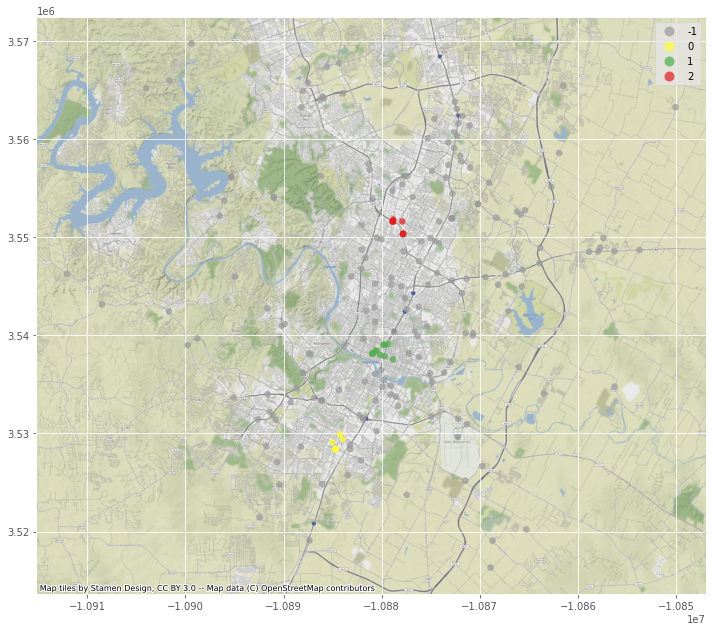

In [150]:
#eps = distance #0.01 degrees = 1.11 km (2 decimals km accuracy)
#min_samples = The number of samples to be considered as a core point, we use 2.5% of the total number of data points

#Define parameters
clusterer = DBSCAN(eps=0.01, min_samples = np.ceil(today.shape[0] * 0.025)) 
# Fit to our data
clusterer.fit(gdf[["latitude", "longitude"]])

#PLOT (Noise = -1)
gdf["labels"] = clusterer.labels_.astype("object")

ax = gdf.plot(figsize = (12,12),
            legend = True, 
            alpha=0.7,
            column = "labels",
            cmap = "Set1_r" )

cx.add_basemap(ax, zoom = 13)

## SPATIO TEMPORAL CLUSTERING

Prepare dataset to fit into algorithm

Source: https://github.com/eren-ck/st_dbscan

In [151]:
#Convert time column to an epoch (seconds since 1970) time column ( we need it for the ST_DBSCAN time)

today['epoch'] = today['published_date'].apply(lambda x: x.timestamp())  #cast epochs

today = today.drop(columns=['traffic_report_id',  
                            'issue_reported', 
                            'location',
                            'address', 
                            'traffic_report_status',
                             'geometry',
                             "published_date"]) #drop non necessary cols

today.rename(columns={'epoch': 'temporal_index',
                    'latitude': 'x',
                    'longitude': 'y'
                    }, inplace=True) #recame to necessary order

today = today.iloc[:,[2,0,1]] #The input data format order is: ['temporal_index','x','y', ] 

Fit Algorithm

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


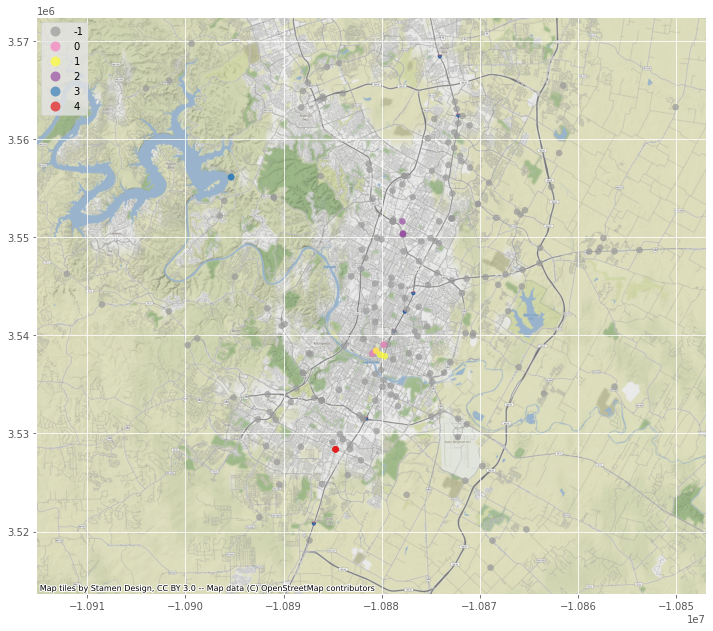

In [161]:
#eps1 = distance #0.01 degrees = 1.11 km (2 decimals km accuracy)
#eps2 = 7200 epochs (seconds) is the equivalent of 2 hours
#min_samples = 3 samples with the eps1 and eps2 constraints

#Define Parameters
st_dbscan = ST_DBSCAN(eps1=0.01, eps2 = 7200, min_samples = 3)
st_dbscan.fit(today)

#PLOT (-1 = NOISE)

gdf["ST_Cluster"] = st_dbscan.labels.astype("object") #add labels to orginal dataset for easier handling

ax = gdf.plot(figsize = (12,12),
            legend = True, 
            alpha=0.7,
            column = "ST_Cluster",
            cmap = "Set1_r" 
            )

cx.add_basemap(ax, zoom = 13)